In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import arff
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, f1_score

# 1. Importation des données

In [2]:
data = arff.loadarff('Dataset/PhishingData.arff')
df_base = pd.DataFrame(data[0])

# 2. Duplication des données

Suite à notre analyse exploratoire, nous avons observé que la classe Result = '0' est sous représentée. Pour éviter que notre modèle ignore cette classe, nous procédons à la duplication des données de cette classe d'un facteur de 4.

In [3]:
suspicious_df = df_base[df_base.Result == b'0'].copy()
df_balanced = df_base.append([suspicious_df]*4, ignore_index=True)

# 3. Encodage des variables

In [4]:
def data_encoding(df):
    label_encoder = LabelEncoder()
    target_var = label_encoder.fit_transform(df.Result)
    tmp = df.drop(['Result'], axis=1)
    df_encoded = OneHotEncoder().fit_transform(tmp).toarray()
    return df_encoded, target_var

# 4. Construction du modèle

In [23]:
TRAIN_PERCENTAGE = 0.8
NBER_OF_TREES = 30

In [9]:
def partition_data(data, target_var):
    tmp = np.concatenate((data, target_var.reshape(len(target_var), 1)), axis=1)
    np.random.shuffle(tmp)
    border = int(len(target_var)*TRAIN_PERCENTAGE)
    X_train = tmp[:border, :-1]
    X_test = tmp[border:, :-1]
    y_train = tmp[:border, -1]
    y_test = tmp[border:, -1]
    return X_train, X_test, y_train, y_test

In [22]:
def build_trees(data, target_var):
    errors = np.array([])
    classifiers = np.array([])

    for i in np.arange(0, NBER_OF_TREES):
        X_train, X_test, y_train, y_test = partition_data(data, target_var)
        
        decision_tree = DecisionTreeClassifier(criterion='gini')
        decision_tree.fit(X_train, y_train)
        classifiers = np.append(classifiers, decision_tree)

        test_predictions = decision_tree.predict(X_test)
        test_error = 1 - accuracy_score(y_test, test_predictions)
        
        errors = np.append(errors, test_error)
    return classifiers, errors

In [33]:
data, target_var = data_encoding(df_balanced.drop(['having_IP_Address'], axis=1))
classifiers_without_ip, errors_without_ip = build_trees(data, target_var)
data, target_var = data_encoding(df_balanced)
classifiers_with_ip, errors_with_ip = build_trees(data, target_var)
errors = np.concatenate((errors_without_ip.reshape(NBER_OF_TREES, 1), errors_with_ip.reshape(NBER_OF_TREES, 1)), axis=1)
errors = pd.DataFrame(errors, columns = ["Sans having_IP_Address", "Avec having_IP_Address"])

In [36]:
pd.DataFrame(errors_without_ip).describe()

,0
count,30.000000
mean,0.086780
std,0.014377
min,0.065156
25%,0.073654
50%,0.086402
75%,0.101275
max,0.113314


In [37]:
pd.DataFrame(errors_with_ip).describe()

,0
count,30.000000
mean,0.089991
std,0.013711
min,0.062323
25%,0.077195
50%,0.092068
75%,0.101275
max,0.110482


Text(0, 0.5, 'Erreur')

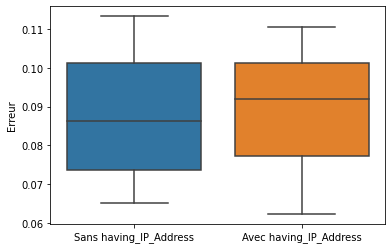

In [39]:
ax = sns.boxplot(data = errors)
ax.set_ylabel("Erreur")

In [40]:
final_classifier_with_ip = classifiers_without_ip[errors_without_ip.argmin()]
final_classifier_without_ip = classifiers_with_ip[errors_with_ip.argmin()]

In [56]:
fig = plt.figure(figsize=(150,150))
plot_tree(final_classifier_without_ip, class_names=["b'-1'", "b'0'", "b'1'"], filled=True)

fig.savefig("decision_tree.jpg")